# EECS 531: Computer Vision Assignment 4
**David Fan**

4/13/18

# Exercise 2

In this notebook we will again be computing the optical flow field of two images in a sequence. This time we will be doing this by using a gradient based method.

## Background
To compute the optical flow field we will first compute the discrete derivative components in the motion gradient constraint equation for a single pixel location of a moving image. We will then compute the matrix $\mathbf A$ and the vector $\mathbf b$ representing the motion gradient equations over a small $n \times n$ patch centered on pixel $(x,y)$. Then we will solve the constraint equations using a least squares solver to estimate the motion vectors $(\mathbf{u}, \mathbf{v})$ at point $(x,y)$. We will use that function to cover a grid of pixel points on the image, but first we should cover some theory.
### Gradient Constraint Equation
If we make the assumption that the intensity of a moving point in an image doesn't change over time such that,

$$
I(x,y,t) = I(x+\partial x, y + \partial y, t + \partial t)
$$

we have:

$$ 
{ \frac{\partial I}{\partial x}} u + { \frac{\partial I}{\partial y}} v + { \frac{\partial I}{\partial t}}= 0
$$
This is the motion gradient constraint equation.

#### Partial Derivatives
At any given point (x,y,t) we can compute the partial derivatives:

$$
\begin{aligned}
I_x &= \frac{I(x+1, y) - I(x-1, y)}{2} \\
I_y &= \frac{I(x, y+1) - I(x, y-1)}{2} \\ 
I_t &= \frac{I(x, t+1) - I(x, t-1)}{2}
\end{aligned}
$$

However, with only two frames we often use the estimate $I_t = I(x, t+1) - I(x,t).$

#### Matrix Form
The motion gradient constraint equation can also be represented in matrix form:
$$
\mathbf{A} \begin{bmatrix} u \\ v\end{bmatrix} = \mathbf{b} t
$$
where:
$$
\begin{aligned}
 \mathbf{A} &= \begin{bmatrix} 
 I_x(x_1) & I_y(x_1) \\ 
 \dots \\
 I_x(x_n) & I_y(x_n)
 \end{bmatrix} \\
\mathbf{b} &= -\begin{bmatrix} I_t(x_1)\\ \dots\\ I_t(x_n)\\\end{bmatrix}\ 
\end{aligned}
$$

This form makes it easy to use regression to solve the motion constraint equation for the motion vectors at a specific point.

## Imports and Preprocessing

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [6]:
def plotflow(I, X, Y, U, V, scale=1, threshold=-1):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
    if threshold > 0:
        mask = np.abs(U + 1j*V) > threshold
        X = X[mask]
        Y = Y[mask]
        U = U[mask]
        V = V[mask]
        
    ax.imshow(I, cmap='gray')
    ax.quiver(X, Y, U*scale, V*scale, color='red', angles='xy', scale_units='xy', scale=1)
    ax.set_aspect('equal')
    plt.show()

seq1 = {'I1': io.imread('data/image/seq1/frame1.png', as_grey=True), 
        'I2': io.imread('data/image/seq1/frame3.png', as_grey=True),
        'U' : np.loadtxt('data/flow/seq1/flow3.u', dtype='double', delimiter=','),
        'V' : np.loadtxt('data/flow/seq1/flow3.v', dtype='double', delimiter=',')}

rubic = {'I1':io.imread('data/rubic/rubic.0.png', as_grey=True), 
         'I2':io.imread('data/rubic/rubic.5.png', as_grey=True)}

sphere= {'I1': io.imread('data/sphere/sphere.1.png', as_grey=True), 
         'I2': io.imread('data/sphere/sphere.3.png', as_grey=True)}


I = np.random.rand(128, 128)
synth = {'I1': I[0:100, 0:100], 
         'I2': I[2:102, 2:102]}

## Compute Partial Derivatives for a Single Pixel Location

In [3]:
def gradient_xyt(I1, I2, x, y):
    h, w = I1.shape
    x = int(x)
    y = int(y)
    
    Ix = (x>0 and x<(w-1) and y>=0 and y<h ) and (I1[y, x+1] - I1[y, x-1])/2 or 0
    Iy = (x>=0 and x<w and y>0 and y< (h-1) ) and (I1[y+1, x] - I1[y-1, x])/2 or 0
    It = (x>=0 and x<w and y>=0 and y<h) and I2[y,x] - I1[y,x] or 0
    return (Ix, Iy, It)

## Compute $\mathbf{A}$ and $\mathbf{b}$ for a Patch Centered on a Pixel

In [16]:
def getAb(I1, I2, x, y, n):
    A = np.zeros((n*n, 2))
    b = np.zeros(n*n)
    
    offset = np.arange(0, n) - np.floor(n/2); 
    dx, dy = np.meshgrid(offset, offset);
    dx = dx.reshape(n*n, 1);
    dy = dy.reshape(n*n, 1);
    
    for i in range(0, n*n):
        Ix, Iy, It = gradient_xyt(I1, I2, x+dx[i], y+dy[i])
        A[i, 0] = Ix 
        A[i, 1] = Iy
        b[i] = -It
        
    return (A, b)

## Solve for the Motion Vectors

In [17]:
def estimate_flow_at_xy(I1, I2, x, y, n):
    A, b = getAb(I1, I2, x, y, n) 
    result = np.linalg.lstsq(np.matmul(A.T, A), np.matmul(A.T, b))
    v = result[0]
    return v

## Find the Motion Vectors at a Grid of Points on the Image

In [18]:
def estimate_flow(I1, I2, gridX, gridY, n):
    H, W = gridX.shape 
    U = np.zeros((H, W))
    V = np.zeros((H, W))
    
    for i in range(0, H):
        for j in range(0, W):
            v =  estimate_flow_at_xy(I1, I2,gridX[i, j], gridY[i, j], n)
            U[i, j] = v[0]
            V[i, j] = v[1]
    return (U, V)

## Compute Optical Flow Field for all Test Images
Similar to what we did in Exercise 1, we will be testing our algorithm on our test image sequences. More detail can be found in Exercise 1.

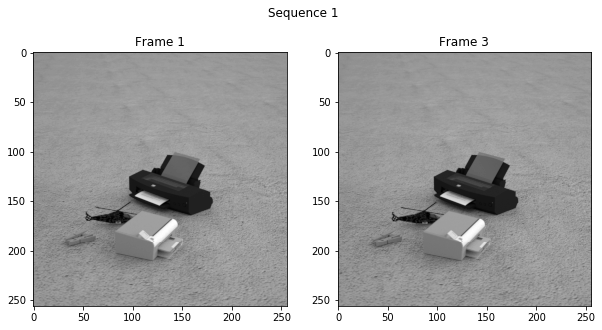

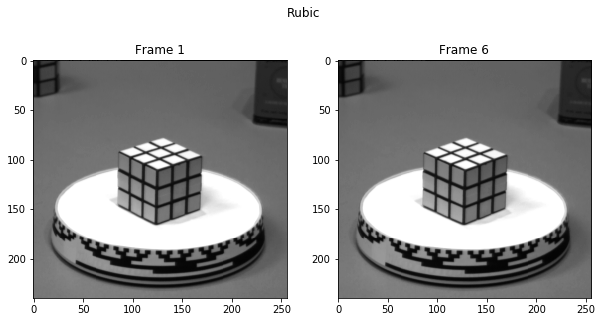

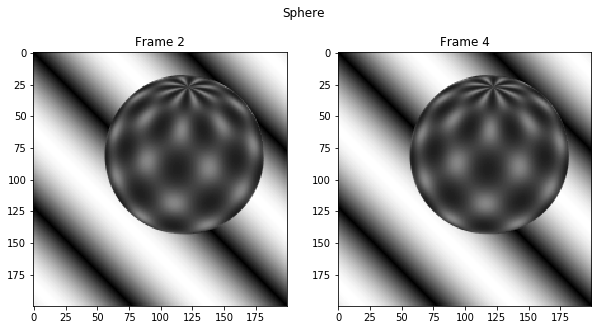

In [19]:
def compare_frames(seq, name, I1_title, I2_title):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle(name)
    axes[0].set_title(I1_title)
    axes[0].imshow(seq["I1"], cmap='gray')
    axes[1].set_title(I2_title)
    axes[1].imshow(seq["I2"], cmap='gray')
    
compare_frames(seq1, "Sequence 1", "Frame 1", "Frame 3")
compare_frames(rubic, "Rubic", "Frame 1", "Frame 6")
compare_frames(sphere, "Sphere", "Frame 2", "Frame 4")

/Users/david/anaconda3/envs/531/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


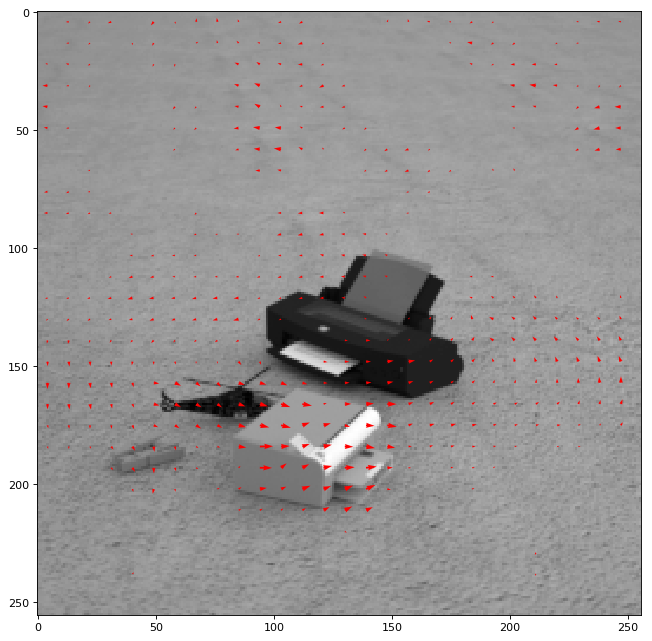

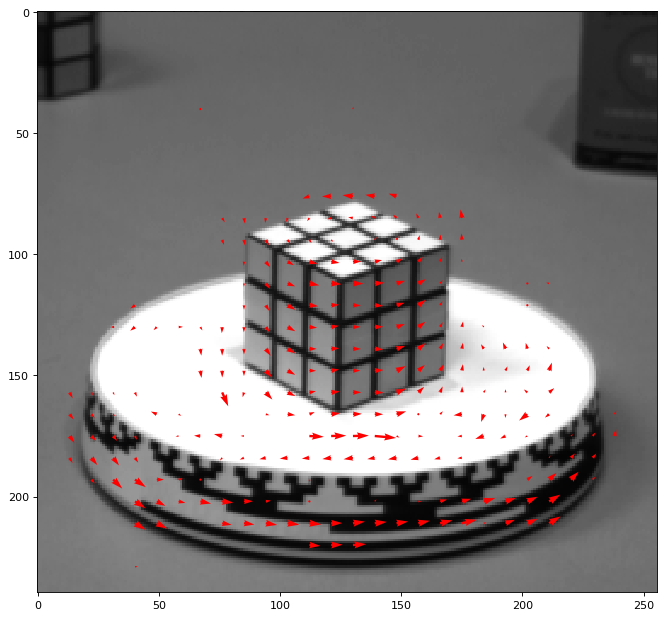

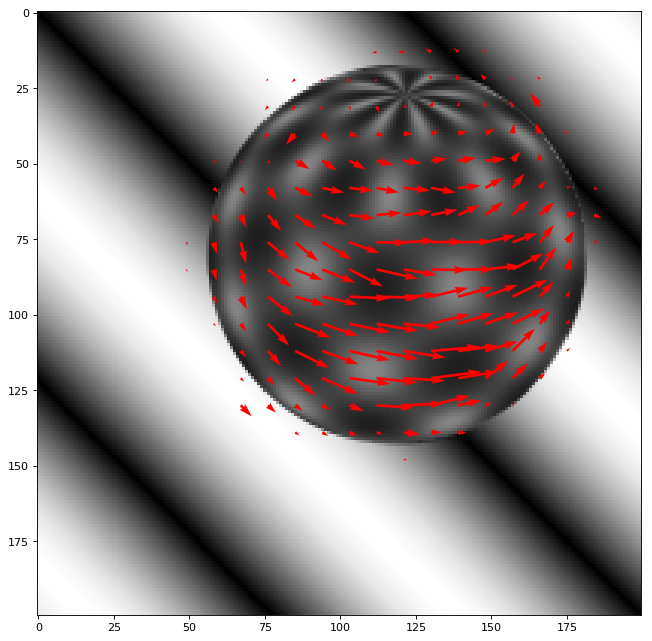

In [20]:
def test_estimate_flow(seq):
    H, W = seq['I1'].shape
    gridsz = 9
    wsz  = 21
    x = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2);
    y = np.arange(0, H-gridsz, gridsz) + np.floor(gridsz/2);
    gridX, gridY = np.meshgrid(x,y);
    U, V = estimate_flow(seq["I1"], seq["I2"], gridX, gridY, wsz)
    plotflow(seq["I1"], gridX, gridY, U, V, 3, 0.3)

test_estimate_flow(seq1)
test_estimate_flow(rubic)
test_estimate_flow(sphere)

The results are quite good! Perhaps a little over sensitive at points, but overall well performing.

## Extension to a random GIF
With this exercise and the past one we were able to test our algorithms on the provided image data. However, for curiousity sake let's download a random gif from the internet (found from [reddit](https://www.reddit.com) and stored in the data folder) and try to calculate the optical flow field between two frames of the GIF.

In [30]:
gif_raw = io.imread('data/test.gif', as_grey=True)
gif = {'I1':gif_raw[0], 
         'I2':gif_raw[3]}

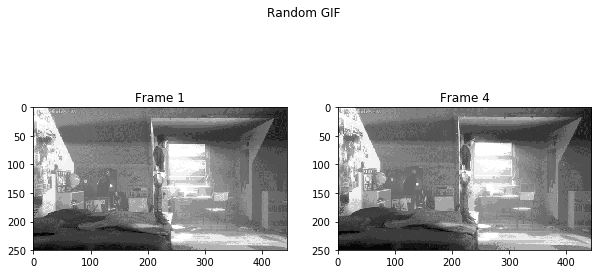

In [31]:
compare_frames(gif, "Random GIF", "Frame 1", "Frame 4")

/Users/david/anaconda3/envs/531/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


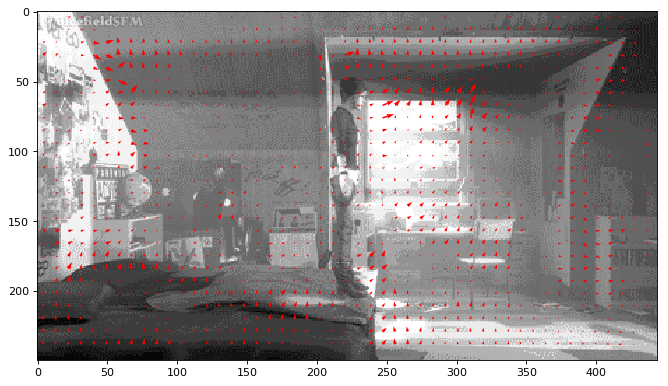

In [32]:
test_estimate_flow(gif)

Let's try a bigger $\Delta t$:

In [59]:
gif2 = {'I1':gif_raw[0], 
         'I2':gif_raw[9]}

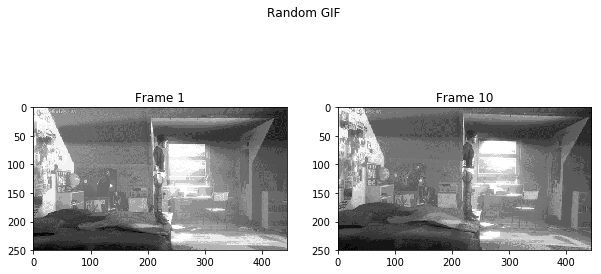

In [60]:
compare_frames(gif2, "Random GIF", "Frame 1", "Frame 10")

/Users/david/anaconda3/envs/531/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


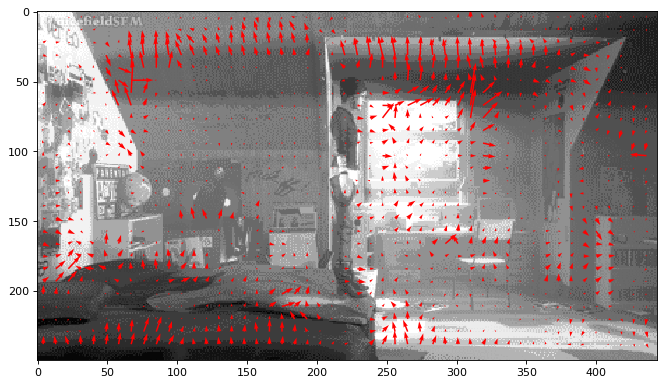

In [61]:
test_estimate_flow(gif2)

Cool!